# Alzheption Feature Extraction and Classification

## Packages

In [2]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import torch
import torchvision as tv
from PIL import Image

from alzheption.clahe import Clahe
from alzheption.extractor import AlzheptionExtractor

In [3]:
def custom_grayscale_threshold(img):
    img[img < 0.5] = 0                                   # Apply thresholding
    return img

## Preprocess

In [4]:
# Original Transformation
dict_transform = {
    "Original": tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Resize((299, 299)),
    ]),
    "Base": tv.transforms.Compose([
        tv.transforms.ToTensor(),
        Clahe(),
        tv.transforms.Resize((299, 299)),
    ]),
    "Normalize": tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Resize((299, 299)),
        tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    "Complex": tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Resize((299, 299)),
        tv.transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontal dengan probabilitas 50%
        tv.transforms.RandomRotation(degrees=15),  # Rotasi gambar antara -15 hingga 15 derajat
        tv.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translasi gambar 10% dari ukuran asli
        tv.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Variasi warna
        tv.transforms.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  # Erasing sebagian gambar untuk regularisasi\
    ]),
    "Equalize": tv.transforms.Compose([
        tv.transforms.RandomEqualize(p=1.),
        tv.transforms.ToTensor(),
        tv.transforms.Resize((299, 299)),
    ]),
    "EqualizeThreshold": tv.transforms.Compose([
        tv.transforms.RandomEqualize(p=1.),
        tv.transforms.ToTensor(),
        tv.transforms.Lambda(custom_grayscale_threshold),
        tv.transforms.Resize((299, 299)),
    ]),
}

name = "Original"
train_transform = dict_transform.get(name)
test_transform = dict_transform.get(name)

## Feature Extraction

In [5]:
list_aug = ["hflip"]
name = f'{name}_{"".join([aug.title() for aug in list_aug])}'
alex_1 = AlzheptionExtractor(
    path_dataset=f'../../asset/dataset_jpg_brightness_balance_augmentation_{"_".join([aug for aug in list_aug])}/',
    test_size=0.2,
    train_transform=train_transform,
    test_transform=test_transform,
)

alex_1.show_dataset_count()

Train dataset size : 912
Test dataset size  : 228


In [7]:
name

'Original_Hflip'

In [8]:
# # Load dataset without transformations
# dataset = tv.datasets.ImageFolder('dataset_jpg_brightness')

# # Split dataset into train and test sets
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_indices, test_indices = torch.utils.data.random_split(range(len(dataset)), [train_size, test_size])

# # Create Subsets with the different transforms applied
# train_dataset = torch.utils.data.Subset(tv.datasets.ImageFolder('dataset_jpg_brightness', transform=train_transform), train_indices.indices)
# test_dataset = torch.utils.data.Subset(tv.datasets.ImageFolder('dataset_jpg_brightness', transform=test_transform), test_indices.indices)

# # DataLoader
# batch_size = 256
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# print(f"Train dataset size: {len(train_dataset)}")
# print(f"Test dataset size: {len(test_dataset)}")

Original Data Test Sample

Get sample of original dataset (test) with index: 744



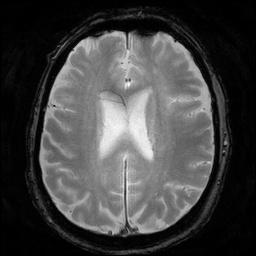

In [9]:
alex_1.get_sample_of_original_dataset(part="test")

Preprocessed Data Test Sample

Get sample of preprocessed dataset (test) with index: 0



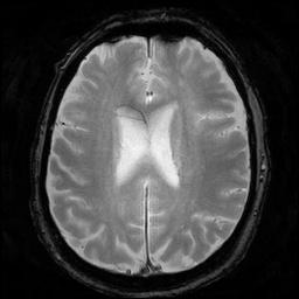

In [10]:
alex_1.get_sample_of_preprocessed_dataset(part="test")

In [11]:
# Load pre-trained InceptionV3 model and set as feature extractor
model = tv.models.inception_v3(weights=True)
model.aux_logits = False
model.fc = torch.nn.Identity()  # Replace fully connected layer with identity for feature extraction

# Move model to GPU if available and use DataParallel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs!')
    model = torch.nn.DataParallel(model)
model = model.to(device)

/home/febriantohuda/projects/alzheption/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extract Features

In [12]:
train_features, test_features = alex_1()

Extracting 'test': 100%|██████████| 1/1 [00:21<00:00, 21.37s/it]


In [13]:
train_features.shape, test_features.shape

((912, 2048), (228, 2048))

Save Features

In [14]:
alex_1.save_extractor(dir_path="result/", suffix=f"_{name}")